In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


# 1. Load the data and get measurements

In [3]:
ROOT_PATH = "/scratch1/04703/sravula/UTAFSDataNew/new_data"
CHIP_NUM = 2

In [4]:
import utils

data_dict = utils.get_network_from_file(ROOT_PATH, CHIP_NUM)

In [5]:
data_dict.keys()

dict_keys(['network', 'fmin', 'fmax', 'length', 'sweep', 'port_pairs'])

## Pre-process the data

In [6]:
data_net = data_dict['network']
data_freqs = data_dict['network'].frequency

In [7]:
print("Frequency stats")
print("Length: %d" % data_freqs.npoints)
print("Spacing: %.4e" % data_freqs.step)
print("Start: %.4e" % data_freqs.start)
print("Stop: %.4e" % data_freqs.stop)

Frequency stats
Length: 581
Spacing: 5.0000e+07
Start: 1.0000e+09
Stop: 3.0000e+10


In [8]:
f_start = data_freqs.start
f_step = data_freqs.step
good_spacing = (f_start / f_step).is_integer()
print("Can extrapolate without aliasing: ", good_spacing)

spacing = data_dict["sweep"]
print("SPACING: ", spacing)

good_chip = good_spacing and (spacing == "LINEAR")
print("GOOD SPACING!!!" if good_chip else "BAD SPACING???")

Can extrapolate without aliasing:  True
SPACING:  LINEAR
GOOD SPACING!!!


In [9]:
print([("%.4e" % s) for s in data_freqs.f[0:5]])

['1.0000e+09', '1.0500e+09', '1.1000e+09', '1.1500e+09', '1.2000e+09']


In [10]:
data_net = data_net.extrapolate_to_dc()
data_freqs = data_net.frequency 

In [11]:
print("Frequency stats")
print("Length: %d" % data_freqs.npoints)
print("Spacing: %.4e" % data_freqs.step)
print("Start: %.4e" % data_freqs.start)
print("Stop: %.4e" % data_freqs.stop)

Frequency stats
Length: 601
Spacing: 5.0000e+07
Start: 0.0000e+00
Stop: 3.0000e+10


In [12]:
print([("%.4e" % s) for s in data_freqs.f[0:5]])

['0.0000e+00', '5.0000e+07', '1.0000e+08', '1.5000e+08', '2.0000e+08']


## Make some variables we will need

In [13]:
def network_to_sparams(network):
    re_mat = network.s.real
    im_mat = network.s.imag
    out_mat = np.stack((re_mat, im_mat), axis=-1)

    out_sparams = utils.matrix_to_sparams(out_mat)

    return torch.from_numpy(out_sparams).view(-1, out_sparams.shape[-1]).unsqueeze(0)

In [14]:
N_FREQS = data_freqs.npoints
N_SPARAMS = int(data_net.nports * (data_net.nports + 1) / 2)

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  601
N_SPARAMS:  10


In [15]:
x = network_to_sparams(data_net).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 20, 601])


In [16]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 10, 601])


## Grab Some Measurements

In [17]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
M = 0.05

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)

Number of Ground Truth Frequency Points:  601
Number of Measurements:  30
Undersampling Ratio:  0.04991680532445923


In [18]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = data_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.npoints)

y shape:  torch.Size([1, 20, 30])
y_freqs shape:  30


In [19]:
y_mag = utils.sparams_to_mag(y)

print("y_mag shape: ", y_mag.shape)

y_mag shape:  torch.Size([1, 10, 30])


In [20]:
z = torch.clone(x)
z[:, :, missing_inds] = 0

print("z shape: ", z.shape)

z shape:  torch.Size([1, 20, 601])


## Plot data and measurements

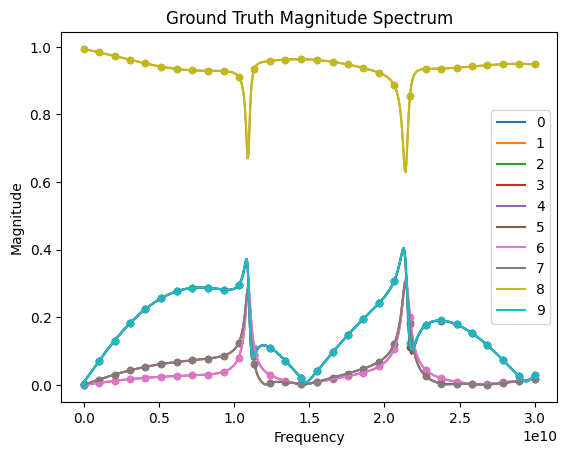

In [21]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(data_freqs.f, x_mag[0, i].cpu(), label=str(i))
    plt.scatter(y_freqs.f, y_mag[0, i].cpu(), s=20)
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

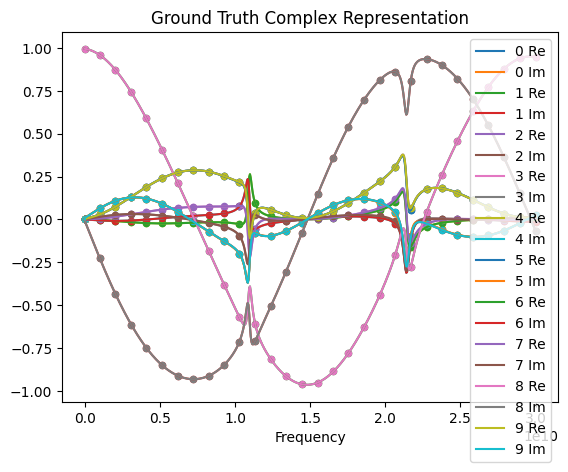

In [22]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(data_freqs.f, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(data_freqs.f, x[0,2*i+1].cpu(), label=str(i)+" Im")
    plt.scatter(y_freqs.f, y[0,2*i].cpu(), s=20)
    plt.scatter(y_freqs.f, y[0,2*i+1].cpu(), s=20)
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

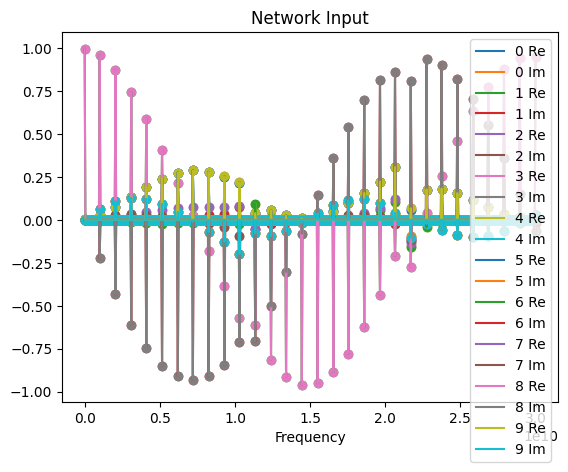

In [23]:
plt.figure()
for i in range(N_SPARAMS):
    plt.scatter(data_freqs.f, z[0,2*i].cpu())
    plt.scatter(data_freqs.f, z[0,2*i+1].cpu())
    plt.plot(data_freqs.f, z[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(data_freqs.f, z[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Network Input")
plt.xlabel("Frequency")
plt.show()

# 2. Network Setup

## Define network parameters

In [24]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 5

if NZ < 16:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 2) #third power of two after NZ 
elif NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NC = y.shape[1]

KERNEL_SIZE = 3
CAUSAL = True
PASSIVE = True

K = 1 #interpolation factor
NEW_CAUSAL = True

In [25]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("CAUSAL: ", CAUSAL)
print("PASSIVE: ", PASSIVE)
print("K: ", K)
print("NEW_CAUSAL", NEW_CAUSAL)

NZ:  20
NUM_LAYERS:  5
BASE NGF:  64
NC:  20
KERNEL_SIZE:  3
CAUSAL:  True
PASSIVE:  True
K:  1
NEW_CAUSAL True


## Init and check dimensions

In [26]:
from models import RESNET_BACKBONE, RESNET_HEAD, MODULAR_RESNET

net_backbone = RESNET_BACKBONE(ngf=BASE_NGF,
                               ngf_in_out=BASE_NGF,
                               kernel_size=KERNEL_SIZE,
                               num_layers=NUM_LAYERS)
net_head = RESNET_HEAD(nz=NZ,
                       ngf_in_out=BASE_NGF,
                       nc=NC,
                       output_size=N_FREQS,
                       kernel_size=KERNEL_SIZE,
                       causal=CAUSAL,
                       passive=PASSIVE,
                       k=K,
                       new_causality=NEW_CAUSAL)

net = MODULAR_RESNET(backbone=net_backbone,
                     head=net_head)
net = net.to(device)

In [27]:
z_temp = torch.randn((1, NZ, N_FREQS)).to(device)

test_out = net.forward(z_temp)

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 20, 601])


In [28]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  401496


## Define training parameters and run

In [29]:
LR = 2e-4 
NUM_ITER = 20000 

REG_HYPERPARAM = 1.0
REG_TYPE = "smoothing"
REG_TARGET = None #this is only sety if we are using centered_wd regularisation
REG_ORDER = 3
REG_NORM = 1

REDUCTION = "mean"

In [30]:
START_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / NUM_ITER) 

print("Noise decay factor: ", NOISE_DECAY_FACTOR)

Noise decay factor:  0.9996546718755381


In [31]:
SGLD = True
BURN_IN_ITER = NUM_ITER - 5000
SAVE_OUTPUT_EVERY = 100

In [32]:
import Fitting

dip_args = {"y": y,
            "x": x,
            "z": z,
            "device": device,
            "model": net,
            "lr": LR,
            "num_iter": NUM_ITER,
            "reg_type": REG_TYPE,
            "reg_lambda": REG_HYPERPARAM,
            "reg_target": REG_TARGET,
            "reg_order": REG_ORDER,
            "reg_norm": REG_NORM,
            "reduction": REDUCTION,
            "kept_inds": kept_inds,
            "input_noise_start": START_NOISE_LEVEL,
            "input_noise_decay": NOISE_DECAY_FACTOR,
            "perturb_weights": SGLD,
            "burn_in_iter": BURN_IN_ITER,
            "save_output_every": SAVE_OUTPUT_EVERY,
            "debug": True}
dip_args = Fitting.dict2namespace(dip_args)

In [33]:
dip_results = Fitting.run_dip(dip_args)

  0%|          | 0/20000 [00:00<?, ?it/s]

# 3. Visualize and get metrics

In [34]:
print(dip_results.__dict__.keys())

dict_keys(['out_list', 'mse_list_gt', 'mse_list_meas', 'mse_list_mean_gt', 'mse_list_mean_meas', 'reg_list'])


In [35]:
print("Final MSE: %.2e" % dip_results.mse_list_gt[-1])
print("Final Mean MSE: %.2e" % dip_results.mse_list_mean_gt[-1])

Final MSE: 3.33e-04
Final Mean MSE: 3.14e-04


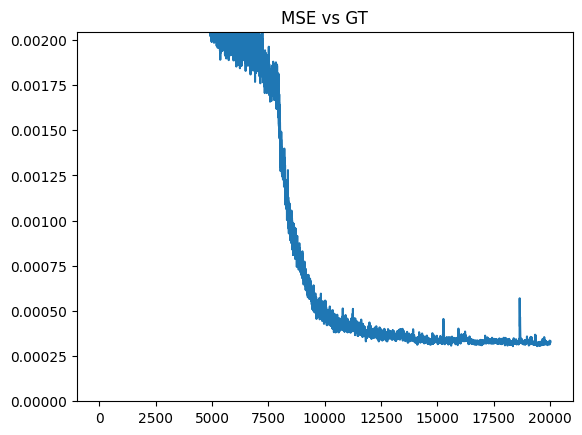

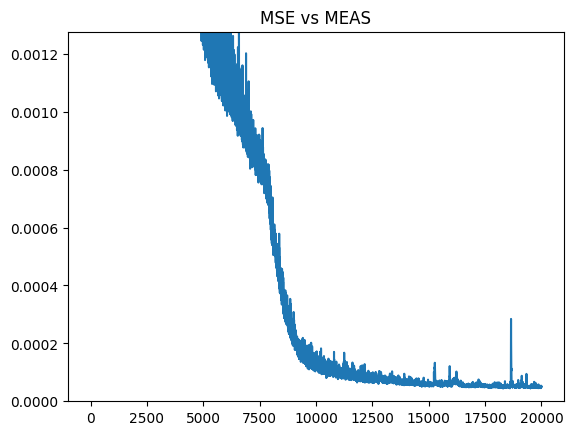

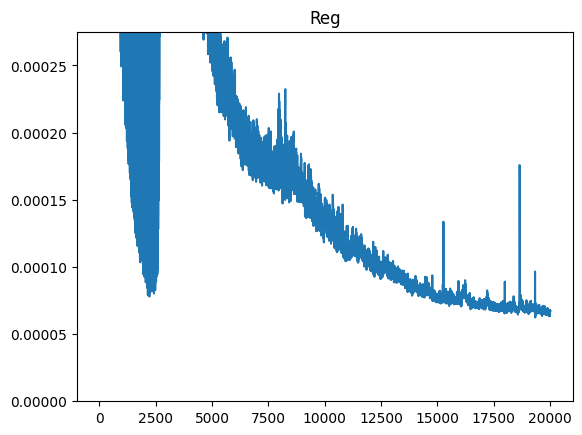

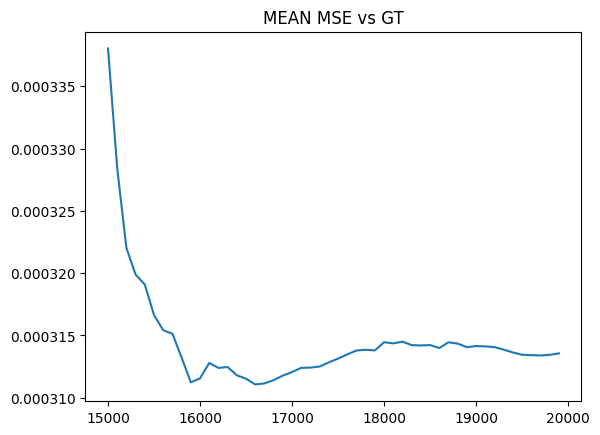

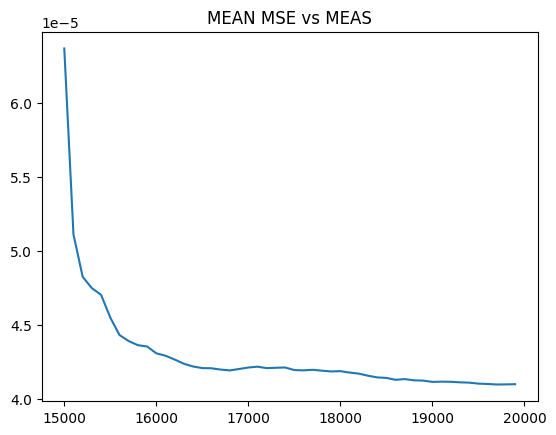

In [36]:
MAX_IDX = 5000

plt.figure()
plt.plot(dip_results.mse_list_gt)
plt.title("MSE vs GT")
plt.ylim(0, dip_results.mse_list_gt[MAX_IDX])
plt.show()

plt.figure()
plt.plot(dip_results.mse_list_meas)
plt.title("MSE vs MEAS")
plt.ylim(0, dip_results.mse_list_meas[MAX_IDX])
plt.show()

if hasattr(dip_results, "reg_list"):
    plt.figure()
    plt.plot(dip_results.reg_list)
    plt.title("Reg")
    plt.ylim(0, dip_results.reg_list[MAX_IDX])
    plt.show()

plt.figure()
plt.plot(np.arange(BURN_IN_ITER, NUM_ITER, SAVE_OUTPUT_EVERY), dip_results.mse_list_mean_gt)
plt.title("MEAN MSE vs GT")
plt.show()

plt.figure()
plt.plot(np.arange(BURN_IN_ITER, NUM_ITER, SAVE_OUTPUT_EVERY), dip_results.mse_list_mean_meas)
plt.title("MEAN MSE vs MEAS")
plt.show()

In [37]:
out_mag_list = [utils.sparams_to_mag(i) for i in dip_results.out_list]

mean_out_mag = torch.mean(torch.cat(out_mag_list), dim=0, keepdim=True)
std_out_mag = torch.std(torch.cat(out_mag_list), dim=0, keepdim=True)

In [38]:
last_out = dip_results.out_list[-1]

last_out_mag = utils.sparams_to_mag(last_out)

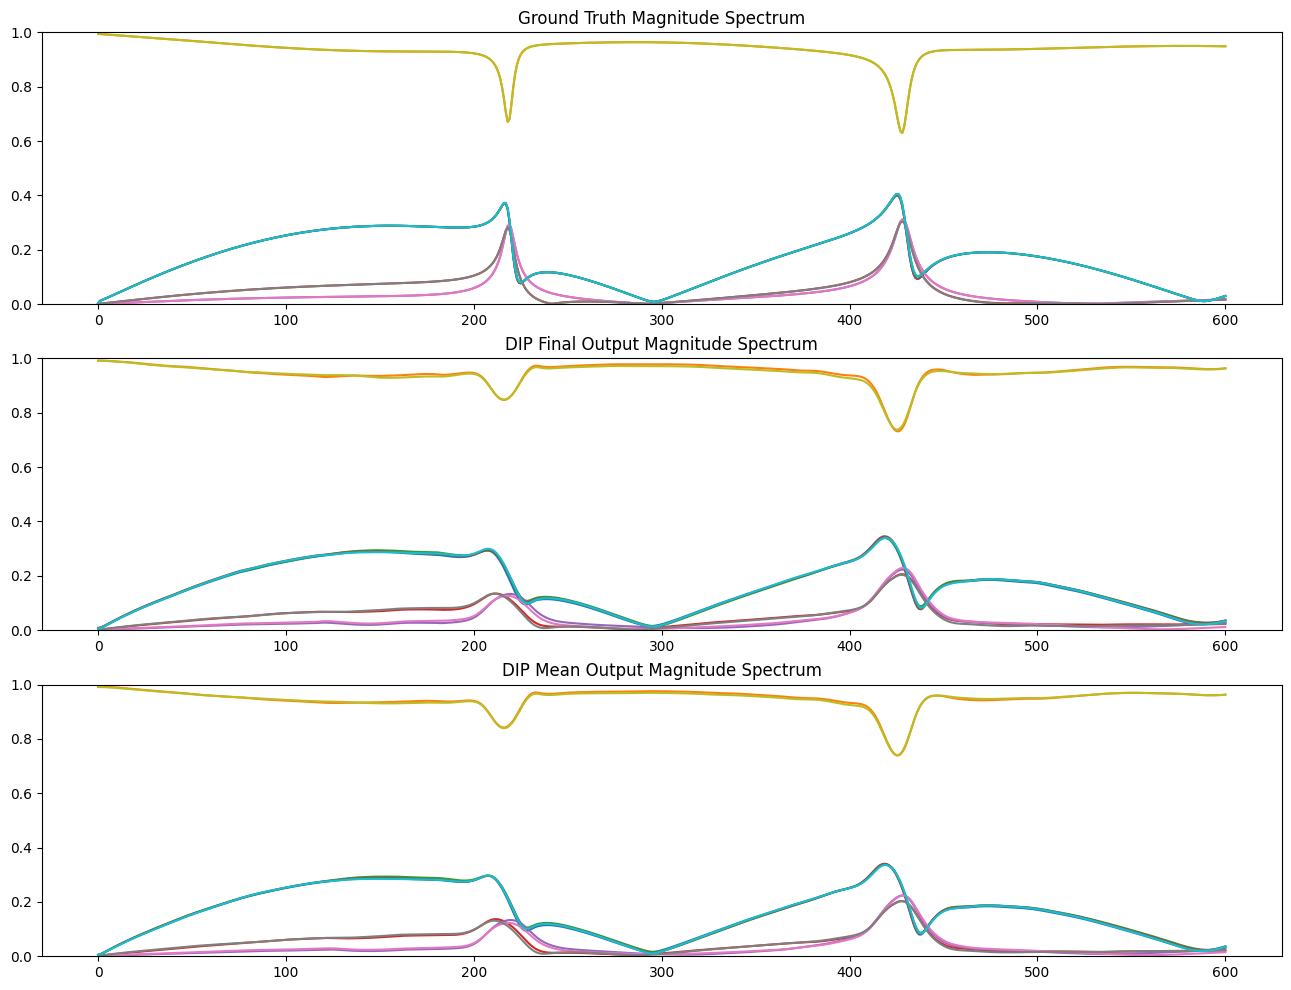

In [39]:
_, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(x_mag.shape[1]):
    axes[0].plot(x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)

for i in range(x_mag.shape[1]):
    axes[1].plot(last_out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Final Output Magnitude Spectrum")
axes[1].set_ylim(0,1)

for i in range(x_mag.shape[1]):
    axes[2].plot(mean_out_mag[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Mean Output Magnitude Spectrum")
axes[2].set_ylim(0,1)

plt.show()

Text(0.5, 1.0, 'Mean')

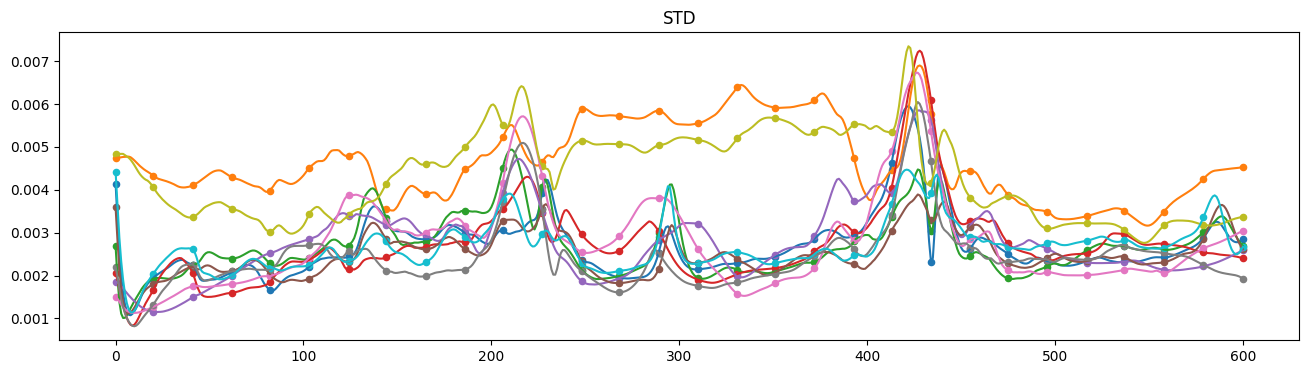

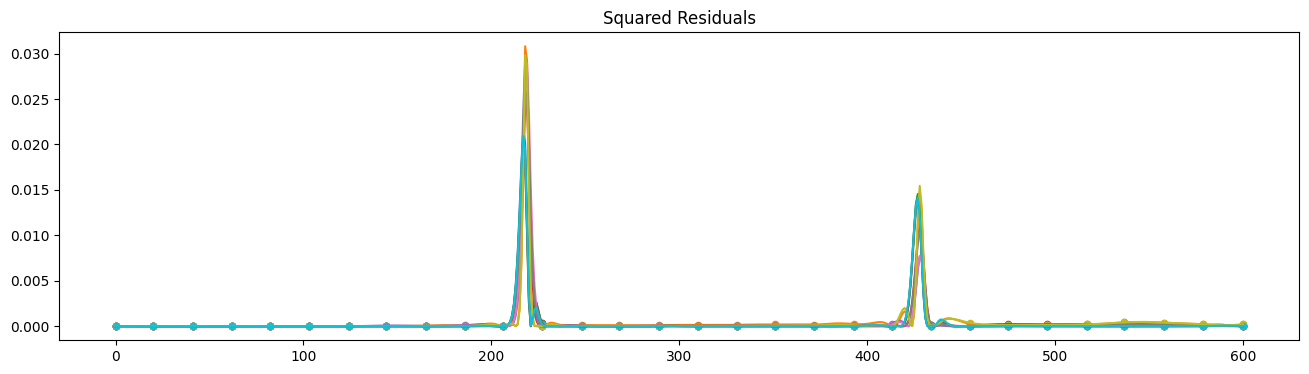

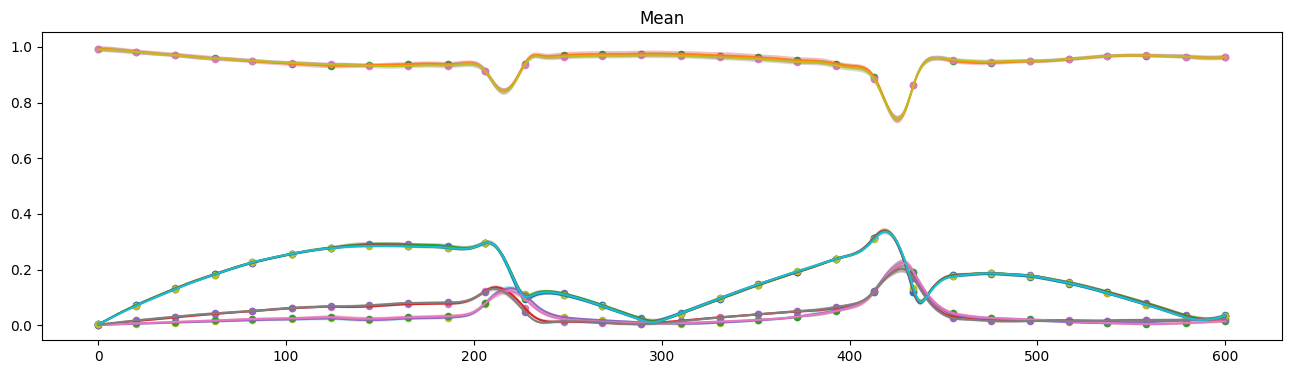

In [40]:
under_line = mean_out_mag - 1.96*std_out_mag
over_line = mean_out_mag + 1.96*std_out_mag

resid_mag = torch.square(x_mag - mean_out_mag)

plt.figure(figsize=(16,4))
for i in range(std_out_mag.shape[1]):
    plt.plot(std_out_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(kept_inds, std_out_mag[0,i][kept_inds].detach().cpu(), s=20)
plt.title("STD")

plt.figure(figsize=(16,4))
for i in range(resid_mag.shape[1]):
    plt.plot(resid_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(kept_inds, resid_mag[0,i][kept_inds].detach().cpu(), s=20)
plt.title("Squared Residuals")

plt.figure(figsize=(16,4))
for i in range(mean_out_mag.shape[1]):
    plt.plot(np.arange(N_FREQS), mean_out_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(kept_inds, mean_out_mag[0,i][kept_inds].detach().cpu(), s=20)
    plt.fill_between(np.arange(N_FREQS), under_line[0,i].detach().cpu(), over_line[0,i].detach().cpu(), alpha=0.3)
plt.title("Mean")

# 4. Post-Processing and File Saving

## check PNSR of our raw outputs

In [41]:
mean_out = torch.mean(torch.cat(dip_results.out_list), dim=0, keepdim=True)

print(mean_out.shape)

torch.Size([1, 20, 601])


In [42]:
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_mean = psnr(x.detach().cpu().numpy(), mean_out.detach().cpu().numpy())
psnr_last = psnr(x.detach().cpu().numpy(), last_out.detach().cpu().numpy())

print("PSNR (MEAN): ", psnr_mean)
print("PSNR (LAST): ", psnr_last)

PSNR (MEAN):  41.05742769977076
PSNR (LAST):  40.891104905248355


## Fit VF on the mean output and the measurements

### First make networks from the DIP outputs and measurements to use with VF 

In [43]:
last_out_matrix = utils.sparams_to_matrix(last_out)
mean_out_matrix = utils.sparams_to_matrix(mean_out)
meas_matrix = utils.sparams_to_matrix(y)

print(last_out_matrix.shape)
print(mean_out_matrix.shape)
print(meas_matrix.shape)

torch.Size([601, 4, 4, 2])
torch.Size([601, 4, 4, 2])
torch.Size([30, 4, 4, 2])


In [44]:
last_out_network = utils.matrix_to_network(last_out_matrix, data_freqs.f, "Last DIP Output for Chip "+str(CHIP_NUM))
mean_out_network = utils.matrix_to_network(mean_out_matrix, data_freqs.f, "Mean DIP Output for Chip "+str(CHIP_NUM))
meas_network = utils.matrix_to_network(meas_matrix, y_freqs.f, "Observations for Chip "+str(CHIP_NUM))

### Now fit the VF

In [45]:
from VF import vectorfit

fitter = vectorfit.VectorFitter(mean_out_network, number_of_failed_improvements_before_quit=5)
fitter_base = vectorfit.VectorFitter(meas_network, number_of_failed_improvements_before_quit=5)

In [46]:
vf_output = fitter.vector_fit("DIP Mean Output", data_freqs.f)

Performing fit with 1 poles.


/work2/04703/sravula/frontera/CurveFitting-DIP/VF/vectorfit.py:232: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.6484360871836543 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.16671659890562296 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 3 (err 0.03541202191972281 vs 0.05409692730381449)
Performing fit with 3 poles.
  Fitting took 0.13449426600709558 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 4 (err 0.009510667074156395 vs 0.03541202191972281)
Performing fit with 4 poles.
  Fitting took 0.18452147487550974 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 4 (err 0.0022367052295127576 vs 0.009510667074156395)
Performing fit with 5 poles.
  Fitting took 0.3293812293559313 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 7 poles better than 6 (er

/work2/04703/sravula/frontera/CurveFitting-DIP/VF/vectorfit.py:232: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. 
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 4.911172330845147 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 14 was not subtantially better than 12 (err 0.0007684661860850604 vs 0.0007247568956120527)
Performing fit with 13 poles.
  Fitting took 5.189796922262758 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 15 was not subtantially better than 12 (err 0.0007048775304423419 vs 0.0007247568956120527)
Performing fit with 14 poles.
  Fitting took 5.68499436089769 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 17 was not subtantially better than 12 (err 0.0007069917336245919 vs 0.0007247568956120527)
Performing fit with 15 poles.
  Fitting took 2.939317016862333 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 17 was not subtantially better than 12 (err 0.0007195591253496569 vs 0.0007247568956120527)
Performing fit with 16 pole

In [47]:
vf_base_output = fitter_base.vector_fit("Measurements", data_freqs.f)
vf_base_output.fitted_network = vectorfit.VectorFitter.fill_fitted_network(data_freqs.f, vf_base_output.vector_fit_model)

Performing fit with 1 poles.


/work2/04703/sravula/frontera/CurveFitting-DIP/VF/vectorfit.py:232: RuntimeWarning: Replacing d_res solution as it was too small. This is not a good sign and probably means that more starting poles are required
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.272082082927227 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.3382050800137222 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 3 (err 0.037426977995596605 vs 0.044126445146864854)
Performing fit with 3 poles.
  Fitting took 0.31116844480857253 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 4 (err 0.017693548256516124 vs 0.037426977995596605)
Performing fit with 4 poles.
  Fitting took 0.4499869798310101 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 was not subtantially better than 4 (err 0.017833944027772185 vs 0.017693548256516124)
Performing fit with 5 poles.
  Fitting took 0.29459048295393586 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles be

/work2/04703/sravula/frontera/CurveFitting-DIP/VF/vectorfit.py:232: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 11059512782.256187). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 4.954850861802697 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 16 poles better than 13 (err 0.00657284760979977 vs 0.007236106826514482)
Performing fit with 14 poles.
  Fitting took 5.4800585438497365 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 17 was not subtantially better than 16 (err 0.006760995523861875 vs 0.00657284760979977)
Performing fit with 15 poles.
  Fitting took 6.113136213738471 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 18 was not subtantially better than 16 (err 0.0066809430373187305 vs 0.00657284760979977)
Performing fit with 16 poles.
  Fitting took 6.8433345588855445 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 19 was not subtantially better than 16 (err 0.006618253340362768 vs 0.00657284760979977)
Performing fit with 17 poles.
  Fitting took 7.364

/work2/04703/sravula/frontera/CurveFitting-DIP/VF/vectorfit.py:232: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 15755823528.807245). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 8.27051120204851 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 21 poles better than 20 (err 0.006068746422462256 vs 0.006335710361026779)
Performing fit with 19 poles.


/work2/04703/sravula/frontera/CurveFitting-DIP/VF/vectorfit.py:232: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 37159300720.62226). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 9.064832048956305 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 22 was not subtantially better than 21 (err 0.005949374194040145 vs 0.006068746422462256)
Performing fit with 20 poles.
  Fitting took 9.827611794229597 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 23 was not subtantially better than 21 (err 0.00626816354863423 vs 0.006068746422462256)
Performing fit with 21 poles.
  Fitting took 10.281708077061921 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 24 was not subtantially better than 21 (err 0.006370924159401304 vs 0.006068746422462256)
Performing fit with 22 poles.
  Fitting took 10.910126799251884 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 25 was not subtantially better than 21 (err 0.0064335144638562455 vs 0.006068746422462256)
Performing fit with 23 poles.
  

In [48]:
vf_out = network_to_sparams(vf_output.fitted_network)

print("vf_out shape: ", vf_out.shape)

vf_out shape:  torch.Size([1, 20, 601])


In [49]:
vf_out_base = network_to_sparams(vf_base_output.fitted_network)

print("vf_out_base shape: ", vf_out_base.shape)

vf_out_base shape:  torch.Size([1, 20, 601])


In [50]:
psnr_vf = psnr(x.detach().cpu().numpy(), vf_out.detach().cpu().numpy())
psnr_vf_base = psnr(x.detach().cpu().numpy(), vf_out_base.detach().cpu().numpy())

print("PSNR (VF): ", psnr_vf)
print("PSNR (VF BASELINE): ", psnr_vf_base)

PSNR (VF):  40.86841147560099
PSNR (VF BASELINE):  37.66571294835758


In [51]:
vf_mag = utils.sparams_to_mag(vf_out)
vf_mag_base = utils.sparams_to_mag(vf_out_base)

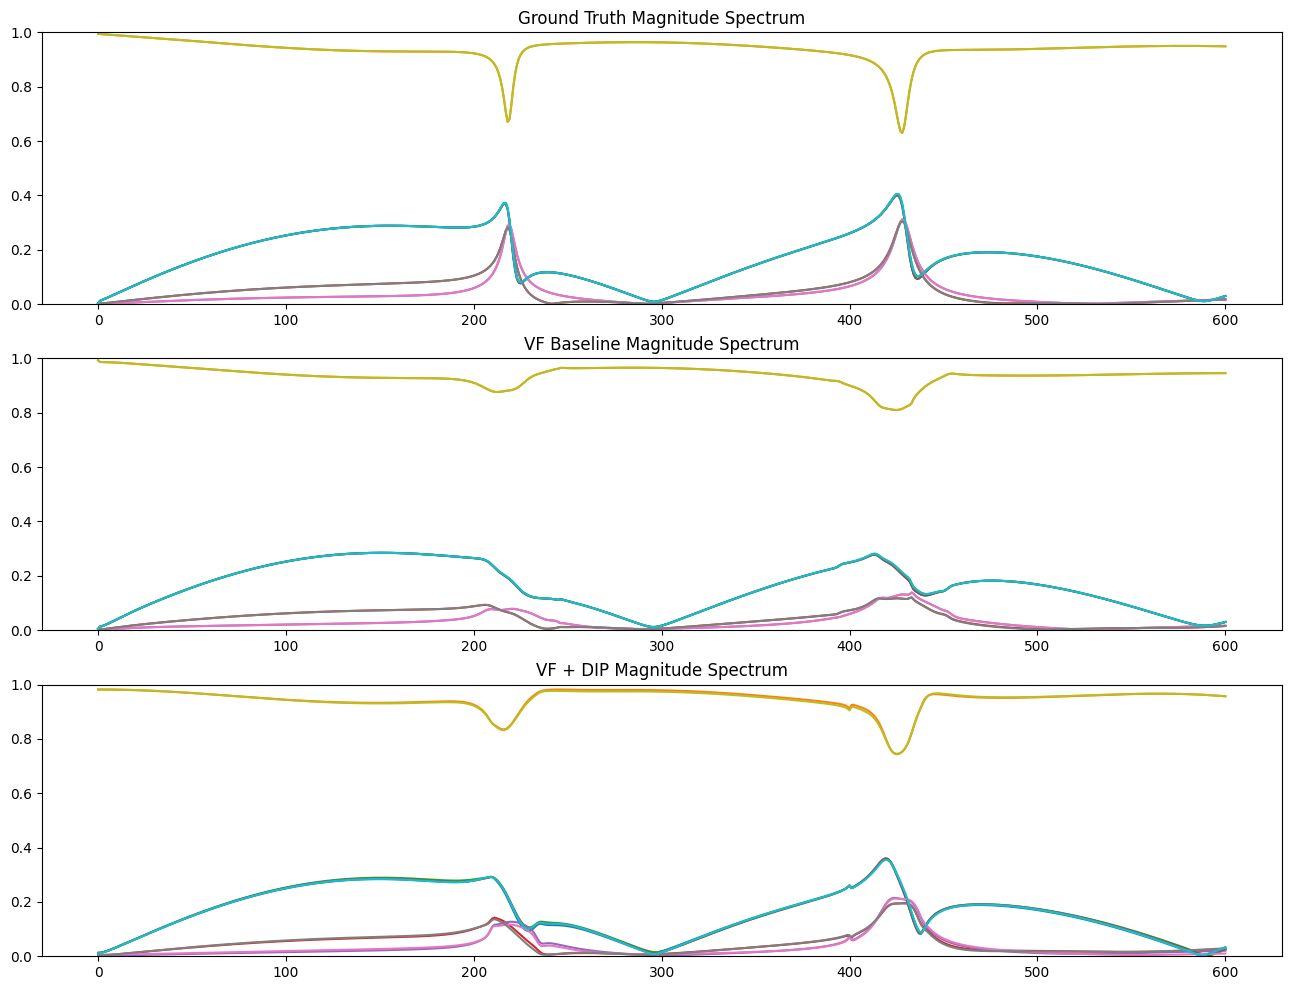

In [52]:
_, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(x_mag.shape[1]):
    axes[0].plot(x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)

for i in range(vf_mag_base.shape[1]):
    axes[1].plot(vf_mag_base[0,i].detach().cpu(), label=str(i))
axes[1].set_title("VF Baseline Magnitude Spectrum")
axes[1].set_ylim(0,1)

for i in range(vf_mag.shape[1]):
    axes[2].plot(vf_mag[0,i].detach().cpu(), label=str(i))
axes[2].set_title("VF + DIP Magnitude Spectrum")
axes[2].set_ylim(0,1)

plt.show()